<a href="https://colab.research.google.com/github/ramzuredha/fyp/blob/main/FasterRCNN_TensorFlow2_Pylon_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Testing on Faster RCNN

In this notebook, we implement [The TensorFlow 2 Object Detection Library](https://blog.tensorflow.org/2020/07/tensorflow-2-meets-object-detection-api.html) for training on your own dataset.

We also recommend reading our blog post on [Train TensorFlow 2 Object Detection on custom data](https://blog.roboflow.com/train-a-tensorflow2-object-detection-model/) side by side.

We will take the following steps to implement YOLOv4 on our custom data:
* Install TensorFlow2 Object Detection Dependencies
* Download Custom TensorFlow2 Object Detection Dataset
* Write Custom TensorFlow2 Object Detection Training Configuation
* Train Custom TensorFlow2 Object Detection Model
* Export Custom TensorFlow2 Object Detection Weights
* Use Trained TensorFlow2 Object Detection For Inference on Test Images


# Configuring cuDNN on Colab 

In [ ]:
# CUDA: Let's check that Nvidia CUDA drivers are already pre-installed and which version is it.
!/usr/local/cuda/bin/nvcc --version
# We need to install the correct cuDNN according to this output

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!nvidia-smi

Thu Oct  7 17:06:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
os.environ['GPU_TYPE'] = str(os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read())

def getGPUArch(argument):
  try:
    argument = argument.strip()
    # All Colab GPUs
    archTypes = {
        "Tesla V100-SXM2-16GB": "-gencode arch=compute_70,code=[sm_70,compute_70]",
        "Tesla K80": "-gencode arch=compute_37,code=sm_37",
        "Tesla T4": "-gencode arch=compute_75,code=[sm_75,compute_75]",
        "Tesla P40": "-gencode arch=compute_61,code=sm_61",
        "Tesla P4": "-gencode arch=compute_61,code=sm_61",
        "Tesla P100-PCIE-16GB": "-gencode arch=compute_60,code=sm_60"

      }
    return archTypes[argument]
  except KeyError:
    return "GPU must be added to GPU Commands"
os.environ['ARCH_VALUE'] = getGPUArch(os.environ['GPU_TYPE'])

print("GPU Type: " + os.environ['GPU_TYPE'])
print("ARCH Value: " + os.environ['ARCH_VALUE'])

GPU Type: Tesla K80

ARCH Value: -gencode arch=compute_37,code=sm_37


# Connect to GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pwd

'/content/gdrive/MyDrive/EfficientDet4'

# Install TensorFlow2 Object Detection Dependencies

In [ ]:
%cd /content/gdrive/MyDrive/EfficientDet4/

/content/gdrive/MyDrive/EfficientDet4


In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd /content/gdrive/MyDrive/EfficientDet4/models/research
protoc object_detection/protos/*.proto --python_out=.
cp /content/gdrive/MyDrive/EfficientDet4/models/research/object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/gdrive/MyDrive/EfficientDet4/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1667806 sha256=c30d48c596b51c3c152b5f682c0655263c5e4f5d2ac85e87a1f2aef45784ec8c
  Stored in directory: /tmp/pip-ephem-wheel-cache-dxwt2tew/wheels/8e/15/1d/d2d6710a8a083eb09a6b6a97bae5c7a11244b36778c7b3816a
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=d3ae99ae7afd0c8d6638484bd179ae5dfe72b7a632cf91dfa34fecbb50dc265d
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for avro-python3: filename=avro_python3-1.9.2.1-py3-none-any.whl size=43512 sha256=83baf6721137f3989a274a62017fe0c098f5c48f8e68b8049125dfc4cc467f78
  Stored in directory: /root/.cache/pip/wheels/bc/49/5f/fdb5b9d85055c478213e0158ac122b596816149a02d82e0ab1
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78546 sha256=18a0a281b6c5bc724a41

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

## Check on the VM (Optional)

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4493163723177402721]

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


IndexError: ignored

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=73f284e1387b5f4fefc6d1333e216b754e2e9fe2762d9fb49db69f0ed13a822d
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


IndexError: ignored

## Run Model Builder Test

In [ ]:
#run model builder test
!python /content/gdrive/MyDrive/EfficientDet4/models/research/object_detection/builders/model_builder_tf2_test.py


2021-10-07 16:57:34.770966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 16:57:35.217954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 16:57:35.218877: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
Running tests under Python 3.7.12: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2021-10-07 16:57:35.239345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

# Prepare Tensorflow 2 Object Detection Training Data


Roboflow automatically creates our TFRecord and label_map files that we need!

**Generating your own TFRecords the only step you need to change for your own custom dataset.**

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll create two separate datasets in Roboflow and generate one set of TFRecords for each.

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/).




![](https://i.imgur.com/ZwMdcbY.png)

In [ ]:
#Downloading data from Roboflow
#UPDATE THIS LINK - get our data from Roboflow
%cd /content/gdrive/MyDrive/EfficientDet4/data
!curl -L "https://app.roboflow.com/ds/tpPYQUcBoX?key=q0mkZaU6Z6" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip



/content/gdrive/MyDrive/EfficientDet4/data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   891  100   891    0     0   1662      0 --:--:-- --:--:-- --:--:--  1659
100 10.9M  100 10.9M    0     0  11.1M      0 --:--:-- --:--:-- --:--:-- 11.1M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/Pylon.tfrecord     
 extracting: test/Pylon_label_map.pbtxt  
   creating: train/
 extracting: train/Pylon.tfrecord    
 extracting: train/Pylon_label_map.pbtxt  
   creating: valid/
 extracting: valid/Pylon.tfrecord    
 extracting: valid/Pylon_label_map.pbtxt  


In [ ]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
test_record_fname = '/content/gdrive/MyDrive/EfficientDet4/data/valid/Pylon.tfrecord'
train_record_fname = '/content/gdrive/MyDrive/EfficientDet4/data/train/Pylon.tfrecord'
label_map_pbtxt_fname = '/content/gdrive/MyDrive/EfficientDet4/data/train/Pylon_label_map.pbtxt'

# Configure Custom TensorFlow2 Object Detection Training Configuration




> In this section you can specify any model in the [TF2 OD model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) and set up your training configuration.



In [ ]:
##change chosen model to deploy different models available in the TF2 object detection zoo
MODELS_CONFIG = {
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
    'efficientdet-d1': {
        'model_name': 'efficientdet_d1_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d1_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
    'efficientdet-d2': {
        'model_name': 'efficientdet_d2_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d2_768x768_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d2_coco17_tpu-32.tar.gz',
        'batch_size': 4
    },
        'efficientdet-d3': {
        'model_name': 'efficientdet_d3_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d3_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d3_coco17_tpu-32.tar.gz',
        'batch_size': 4
    }
}

#in this tutorial we implement the lightweight, smallest state of the art efficientdet model
#if you want to scale up tot larger efficientdet models you will likely need more compute!
chosen_model = 'efficientdet-d2'

num_steps = 3000 #The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
num_eval_steps = 250 #Perform evaluation after so many steps

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']
batch_size = MODELS_CONFIG[chosen_model]['batch_size'] #if you can fit a large batch in memory, it may speed up your training

In [ ]:
#Alternative for other model 
num_steps = 3000 #The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
num_eval_steps = 500 #Perform evaluation after so many steps

model_name     = 'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8'
base_pipeline_file = 'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.config'
pretrained_checkpoint = 'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz'
batch_size = 4 #if you can fit a large batch in memory, it may speed up your training

In [ ]:
#download pretrained weights
%mkdir /content/gdrive/MyDrive/EfficientDet4/models/research/deploy/
%cd /content/gdrive/MyDrive/EfficientDet4/models/research/deploy/
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint
#download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_1024x1024_coco17_tpu-8.tar.gz'
#download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz'


!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

mkdir: cannot create directory ‘/content/gdrive/MyDrive/EfficientDet4/models/research/deploy/’: File exists
/content/gdrive/MyDrive/EfficientDet4/models/research/deploy
--2021-10-07 17:17:45--  http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.136.128, 2607:f8b0:4001:c34::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.136.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353643040 (337M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz’

faster_rcnn_resnet1 100%[===================>] 337.26M  41.9MB/s    in 8.0s    

2021-10-07 17:17:53 (42.0 MB/s) - ‘faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz’ saved [353643040/353643040]



In [ ]:
#download base training configuration file
%cd /content/gdrive/MyDrive/EfficientDet4/models/research/deploy
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

/content/gdrive/MyDrive/EfficientDet4/models/research/deploy
--2021-10-07 17:18:06--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3531 (3.4K) [text/plain]
Saving to: ‘faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.config’

faster_rcnn_resnet1 100%[===================>]   3.45K  --.-KB/s    in 0.001s  

2021-10-07 17:18:06 (2.90 MB/s) - ‘faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.config’ saved [3531/3531]



In [ ]:
#prepare
pipeline_fname = '/content/gdrive/MyDrive/EfficientDet4/models/research/deploy/' + base_pipeline_file 
fine_tune_checkpoint = '/content/gdrive/MyDrive/EfficientDet4/models/research/deploy/' + model_name + '/checkpoint/ckpt-0' 

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)


In [ ]:
#write custom configuration file by slotting our dataset, model checkpoint, and training parameters into the base pipeline file

import re

%cd /content/gdrive/MyDrive/EfficientDet4/models/research/deploy/
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    
    #fine-tune checkpoint type
    s = re.sub(
        'fine_tune_checkpoint_type: "detection"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
        
    f.write(s)



/content/gdrive/MyDrive/EfficientDet4/models/research/deploy
writing custom configuration file


In [ ]:
# edit manualy the pipeline on the  	
## Use_bfloat16 = false 
## total_step and num_step 

In [ ]:
%cat /content/gdrive/MyDrive/EfficientDet4/models/research/deploy/pipeline_file.config

# Faster R-CNN with Resnet-50 (v1)
# Trained on COCO, initialized from Imagenet classification checkpoint
#
# Train on TPU-8
#
# Achieves 31.8 mAP on COCO17 val

model {
  faster_rcnn {
    num_classes: 2
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 640
        max_dimension: 640
        pad_to_max_dimension: true
      }
    }
    feature_extractor {
      type: 'faster_rcnn_resnet101_keras'
      batch_norm_trainable: true
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_thresh

In [ ]:
pipeline_file = '/content/gdrive/MyDrive/EfficientDet4/models/research/deploy/pipeline_file.config'
model_dir = '/content/gdrive/MyDrive/EfficientDet4/training/'

# Train Custom TF2 Object Detector

* pipeline_file: defined above in writing custom training configuration
* model_dir: the location tensorboard logs and saved model checkpoints will save to
* num_train_steps: how long to train for
* num_eval_steps: perform eval on validation set after this many steps







In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
!python /content/gdrive/MyDrive/EfficientDet4/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

2021-10-07 17:20:09.148740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 17:20:09.158530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 17:20:09.159492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 17:20:09.161321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 17:20:09.162197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

## Evaluation of the model

In [ ]:
#run model evaluation to obtain performance metrics
!python /content/gdrive/MyDrive/EfficientDet4/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --checkpoint_dir={model_dir} \
#Not yet implemented for EfficientDet

2021-10-07 18:47:16.007425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 18:47:16.070218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 18:47:16.071110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
W1007 18:47:16.078683 140593405110144 model_lib_v2.py:1082] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I1007 18:47:16.078987 140593405110144 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat

## Tensorboard

In [ ]:
%reload_ext tensorboard

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir '/content/gdrive/MyDrive/EfficientDet4/training/eval' 

Reusing TensorBoard on port 6006 (pid 561), started 0:02:35 ago. (Use '!kill 561' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
%tensorboard --logdir '/content/gdrive/MyDrive/EfficientDet4/training/train'

<IPython.core.display.Javascript object>

## Exporting a Trained Inference Graph
Still to come for TF2 models, we will be updating this Colab notebook accordingly as the functionality is added. 

In [ ]:
#see where our model saved weights
%ls '/content/gdrive/MyDrive/EfficientDet4/training/' 

checkpoint                  ckpt-2.index                ckpt-4.index
ckpt-1.data-00000-of-00001  ckpt-3.data-00000-of-00001  eval/
ckpt-1.index                ckpt-3.index                train/
ckpt-2.data-00000-of-00001  ckpt-4.data-00000-of-00001


In [ ]:
#run conversion script
import re
import numpy as np

output_directory = '/content/gdrive/MyDrive/EfficientDet4/export/'

#place the model weights you would like to export here
last_model_path = '/content/gdrive/MyDrive/EfficientDet4/training/'
print(last_model_path)
!python /content/gdrive/MyDrive/EfficientDet4/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

/content/gdrive/MyDrive/EfficientDet4/training/
2021-10-07 19:03:20.285868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 19:03:20.305175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 19:03:20.305937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 19:03:20.336256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 19:03:20.337044: I tensorflow/stream_executor/cuda/cuda_gpu_e

In [ ]:
%ls '/content/gdrive/MyDrive/EfficientDet4/export/saved_model/' ####

assets/  saved_model.pb  variables/


# Run Inference on Test Images with Custom TensorFlow2 Object Detector

In [ ]:
#downloading test images from Roboflow
#export dataset above with format COCO JSON
#or import your test images via other means. 
%mkdir /content/gdrive/MyDrive/EfficientDet4/test/
%cd /content/gdrive/MyDrive/EfficientDet4/test/
!curl -L "https://app.roboflow.com/ds/grJC4GVHIm?key=2aCgVZIjJ7" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

mkdir: cannot create directory ‘/content/gdrive/MyDrive/EfficientDet4/test/’: File exists
/content/gdrive/MyDrive/EfficientDet4/test
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   1749      0 --:--:-- --:--:-- --:--:--  1749
100 23.0M  100 23.0M    0     0  18.2M      0  0:00:01  0:00:01 --:--:-- 36.4M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/11_jpg.rf.032adb7a3a0ad38197cd7f95ce763f90.jpg  
 extracting: test/19_jpg.rf.1114a1ebca3957cc7e3edd0f320c05d5.jpg  
 extracting: test/1_jpg.rf.0806cfb7783de691558c14071aa40bc8.jpg  
 extracting: test/27_jpg.rf.8e3bc9d6ca35d1360cfca9e23157e3d1.jpg  
 extracting: test/38_jpg.rf.e39063bc9d156fc8d1a06d681d74526f.jpg  
 extracting: test/71_jpg.rf.d8ec7a6976b60b6de41900573e33a701.jpg  
 extracting: test/73_jpg.rf.179b63955da57bd7efb9fd5be19def65.jpg  
 ex

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
%ls '/content/gdrive/MyDrive/EfficientDet4/training/' 

checkpoint                  ckpt-2.index                ckpt-4.index
ckpt-1.data-00000-of-00001  ckpt-3.data-00000-of-00001  eval/
ckpt-1.index                ckpt-3.index                train/
ckpt-2.data-00000-of-00001  ckpt-4.data-00000-of-00001


In [ ]:
import pathlib

filenames = list(pathlib.Path('/content/gdrive/MyDrive/EfficientDet4/training/').glob('*.index'))

filenames.sort()
print(filenames)

#recover our saved model
pipeline_config = pipeline_file
#generally you want to put the last ckpt from training in here
model_dir = str(filenames[-1]).replace('.index','')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

[PosixPath('/content/gdrive/MyDrive/EfficientDet4/training/ckpt-1.index'), PosixPath('/content/gdrive/MyDrive/EfficientDet4/training/ckpt-2.index'), PosixPath('/content/gdrive/MyDrive/EfficientDet4/training/ckpt-3.index'), PosixPath('/content/gdrive/MyDrive/EfficientDet4/training/ckpt-4.index')]


In [ ]:
#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

In [ ]:
pwd

'/content/gdrive/MyDrive/EfficientDet4/test'

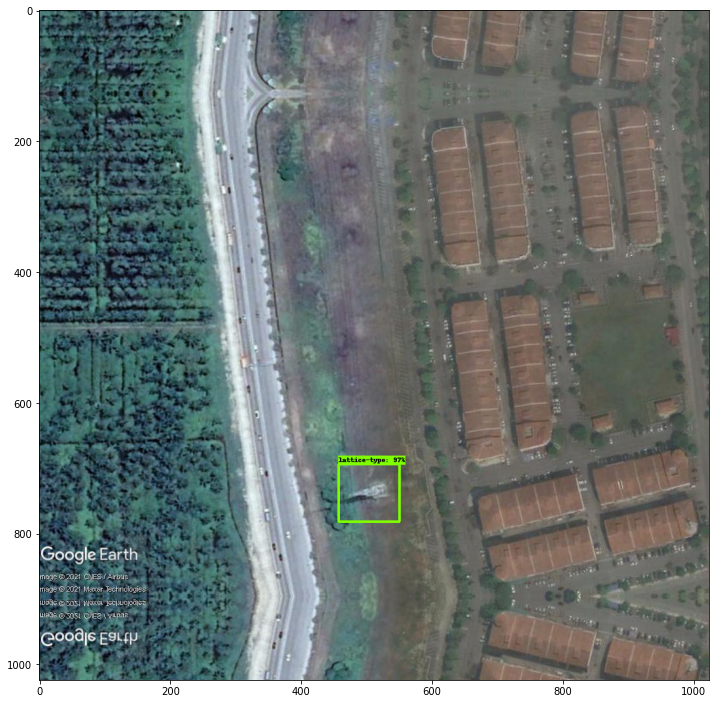

In [ ]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random
from cv2 import cv2
num = 6

TEST_IMAGE_PATHS = glob.glob('/content/gdrive/MyDrive/EfficientDet4/test/test/4.jpg') 
image_path = random.choice(TEST_IMAGE_PATHS)
image_np = load_image_into_numpy_array(image_path)
save_path = '/content/gdrive/MyDrive/EfficientDet4/'
# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.5,
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

#%cd /content/gdrive/MyDrive/EfficientDet4/test
#cv2.imwrite("output11.png", image_np_with_detections)






## Congrats!

Hope you enjoyed this!

--Team [Roboflow](https://roboflow.ai)
